In [6]:
import numpy as np
import pandas as pd
# import matplotlib as plt
from matplotlib import pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, sampler

import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import *
import os


import time
import random
%matplotlib inline
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
path = "/Users/mucheng/Datasets/RetinalOCT/OCT2017/"

In [8]:
batch_size = 128
target_size = (224, 224)

def load_datasets():
    transform = transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5))
    ])
    
    trainset = torchvision.datasets.ImageFolder(
        root = "/Users/mucheng/Datasets/RetinalOCT/OCT2017 /train",
        transform = transform
    )
    validset = torchvision.datasets.ImageFolder(
        root = "/Users/mucheng/Datasets/RetinalOCT/OCT2017 /val",
        transform = transform
    )
    testset = torchvision.datasets.ImageFolder(
        root = "/Users/mucheng/Datasets/RetinalOCT/OCT2017 /test",
        transform = transform
    )
    
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, valid_dataloader, test_dataloader
    

In [9]:
# train,valid,test = load_datasets()

# images, labels = next(iter(train))
# img = torchvision.utils.make_grid(images)

# img = img.numpy().transpose(1, 2, 0)
# std = [0.5, 0.5, 0.5]
# mean = [0.5, 0.5, 0.5]
# img = img * std + mean
# plt.imshow(img)
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


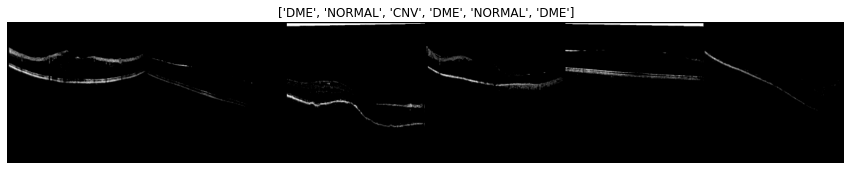

In [10]:
def imshow(y, title):
    y = y.numpy().transpose((1,2,0))
    plt.figure(figsize=(15,15))
    plt.imshow(y)
    plt.axis('off')
    plt.title(title)
    
def imagebatch(y, classes):
    out = torchvision.utils.make_grid(y)
    imshow(out, title=[labels[i] for i in classes])

labels = ["CNV", "DME", "DRUSEN", "NORMAL"]
train,valid,test = load_datasets()
img,classes = next(iter(train))
imagebatch(img[0:6], classes[0:6])

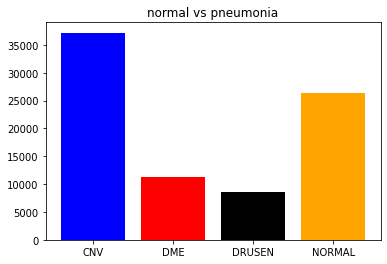

In [11]:
train_cnv = "/Users/mucheng/Datasets/RetinalOCT/OCT2017 /train/CNV"
train_dme = "/Users/mucheng/Datasets/RetinalOCT/OCT2017 /train/DME"
train_drusen = "/Users/mucheng/Datasets/RetinalOCT/OCT2017 /train/DRUSEN"
train_normal = "/Users/mucheng/Datasets/RetinalOCT/OCT2017 /train/NORMAL"

plt.title('normal vs pneumonia')
plt.bar(labels, 
        [len(os.listdir(train_cnv)), 
         len(os.listdir(train_dme)),
        len(os.listdir(train_drusen)),
        len(os.listdir(train_normal))],
        color=['blue', 'red', 'black', 'orange'])
plt.show()

## Buiding a CNN Model for the Original Dataset 

In [151]:
for X, label_y in test:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {label_y.shape} {label_y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 224, 224])
Shape of y: torch.Size([128]) torch.int64


In [ ]:
# model = torchvision.models.resnet18(pretrained=True)

# model.fc = torch.nn.Linear(512, len(unique_class))

# criterion = torch.nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, eps=1e-06)



In [13]:
n_classes = 4
class_names = labels
# Create a convolutional neural network 
class ModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3136, 
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [14]:
# Following code appears at: https://lirnli.wordpress.com/2017/09/03/one-hot-encoding-in-pytorch/
class One_Hot(nn.Module):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = torch.sparse.torch.eye(depth).to(device)
    def forward(self, X_in):
        X_in = X_in.long()
        return self.ones.index_select(0,X_in.data)

    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

In [15]:
# This probably exists already
def printif(message, isPrint):
    if isPrint:
        print(message)

predicted = list()
true = list()

# Test the model on the given dataset.
def test(model, dataset):
    model.eval()

    # Define loss, one_hot and variables
    mloss = nn.CrossEntropyLoss()
    one_hot = One_Hot(2).to(device)
    correct = 0
    loss_total = 0
    
    with torch.no_grad():
        for data, target in dataset:
            
            true.append(torch.tensor(target).numpy())
            # Convert data and target to device
            data = data.to(device)
            target = target.to(device)

            # Get network output, loss and correct
            output = model(data)
            loss = mloss(output, target)
            _, pred = torch.max(output.data, dim=1)
            
            predicted.append(torch.tensor(pred).numpy())

            # Update correct and loss
            correct += pred.eq(target.data.view_as(pred)).sum().item()
            loss_total += loss.item()

    return 100. * correct / len(dataset.dataset), loss_total/ len(dataset.dataset)

def train(model, trainset, validset, learning_rate=0.001, decay=0, epochs=10, valid_interval=1, log_interval=10, console_logging=True):

    # Logging curves
    loss_curve = []
    accuracy_curve =[]
    validation_accuracy_curve = []
    validation_loss_curve = []
    
    # Loss and one hot
    mloss = nn.CrossEntropyLoss()
    one_hot = One_Hot(2).to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

    max_accuracy = -1
    for epoch in range(1, epochs+1):

        epoch_loss = 0
        epoch_accuracy = 0

        for batch_idx, (data, target) in enumerate(trainset):
            model.train()

            # Convert data to device
            data = data.to(device)
            target = target.to(device).long()

            # Zerograd optimizer as pytorch will add gradients together if not cleared
            optimizer.zero_grad()

            # Get the output, calculate loss
            output = model(data)
            loss = mloss(output, target)

            epoch_loss += loss.item()

            # Compute the backwards update step, send it to optimizer
            loss.backward()
            optimizer.step()

            # Get correct items for logging
            _, pred = torch.max(output.data, dim=1)
            #print("Pred: " + str(pred))
            #print("Correct: " + str(target))
            correct = pred.eq(target.data.view_as(pred)).sum()
            epoch_accuracy += correct.item()

            if batch_idx % log_interval == 0:
                printif('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                    epoch, batch_idx * batch_size, len(trainset.dataset),
                                    100. * (batch_idx * batch_size) / len(trainset.dataset), loss.item()), console_logging)
                
        # Add logged items to their curves
        loss_curve.append(epoch_loss / len(trainset.dataset))
        accuracy_curve.append(epoch_accuracy / len(trainset.dataset))

        # If we are a validation interval, validate and save best model.
        if epoch % valid_interval == 0:
            printif("Starting Validation Step:", console_logging)
            accuracy_val, loss_val = test(model, validset)
            validation_accuracy_curve.append(accuracy_val)
            validation_loss_curve.append(loss_val)
            printif("Validation Dataset - Accuracy: %.2f, Loss: %.4f" % (accuracy_val, loss_val), console_logging)
            if accuracy_val > max_accuracy:
                printif("New optimal validation value recieved!", console_logging)
                #torch.save(model, "/kaggle/output/model.pnt")
                max_accuracy = accuracy_val

    return loss_curve, accuracy_curve, validation_loss_curve, validation_accuracy_curve

In [16]:
trainset, valset, testset = load_datasets()
print("Loaded train, val and test with sizes: %d, %d, %d" % (len(trainset.dataset), len(valset.dataset), len(testset.dataset)))
model = ModelV1(input_shape=3, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
print("Input Size: %d" % (target_size[0] * target_size[1]))
trainloss, trainaccuracy, validloss, validaccuracy = train(model, trainset, valset, epochs=10, decay=0, valid_interval=2, learning_rate=0.0001)

Loaded train, val and test with sizes: 83484, 32, 968
Input Size: 50176
Train Epoch: 1 [0/83484 (0%)]	Loss: 1.386054
Train Epoch: 1 [1280/83484 (2%)]	Loss: 1.215720
Train Epoch: 1 [2560/83484 (3%)]	Loss: 1.190927
Train Epoch: 1 [3840/83484 (5%)]	Loss: 1.131634
Train Epoch: 1 [5120/83484 (6%)]	Loss: 1.234036
Train Epoch: 1 [6400/83484 (8%)]	Loss: 1.246536
Train Epoch: 1 [7680/83484 (9%)]	Loss: 1.211674
Train Epoch: 1 [8960/83484 (11%)]	Loss: 1.305477
Train Epoch: 1 [10240/83484 (12%)]	Loss: 1.179703
Train Epoch: 1 [11520/83484 (14%)]	Loss: 1.269508
Train Epoch: 1 [12800/83484 (15%)]	Loss: 1.215460
Train Epoch: 1 [14080/83484 (17%)]	Loss: 1.205226
Train Epoch: 1 [15360/83484 (18%)]	Loss: 1.205036
Train Epoch: 1 [16640/83484 (20%)]	Loss: 1.146232
Train Epoch: 1 [17920/83484 (21%)]	Loss: 1.239892
Train Epoch: 1 [19200/83484 (23%)]	Loss: 1.226056
Train Epoch: 1 [20480/83484 (25%)]	Loss: 1.236781
Train Epoch: 1 [21760/83484 (26%)]	Loss: 1.292816
Train Epoch: 1 [23040/83484 (28%)]	Loss: 1.107

/var/folders/dw/_3hp0rfn7rngzth_1dc9rh280000gn/T/ipykernel_7747/3064916726.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true.append(torch.tensor(target).numpy())
/var/folders/dw/_3hp0rfn7rngzth_1dc9rh280000gn/T/ipykernel_7747/3064916726.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted.append(torch.tensor(pred).numpy())


Validation Dataset - Accuracy: 68.75, Loss: 0.0233
New optimal validation value recieved!
Train Epoch: 3 [0/83484 (0%)]	Loss: 0.631077
Train Epoch: 3 [1280/83484 (2%)]	Loss: 0.606257
Train Epoch: 3 [2560/83484 (3%)]	Loss: 0.740371
Train Epoch: 3 [3840/83484 (5%)]	Loss: 0.701110
Train Epoch: 3 [5120/83484 (6%)]	Loss: 0.740356
Train Epoch: 3 [6400/83484 (8%)]	Loss: 0.606335
Train Epoch: 3 [7680/83484 (9%)]	Loss: 0.596970
Train Epoch: 3 [8960/83484 (11%)]	Loss: 0.619896
Train Epoch: 3 [10240/83484 (12%)]	Loss: 0.636661
Train Epoch: 3 [11520/83484 (14%)]	Loss: 0.557052
Train Epoch: 3 [12800/83484 (15%)]	Loss: 0.759868
Train Epoch: 3 [14080/83484 (17%)]	Loss: 0.747160
Train Epoch: 3 [15360/83484 (18%)]	Loss: 0.703931
Train Epoch: 3 [16640/83484 (20%)]	Loss: 0.699001
Train Epoch: 3 [17920/83484 (21%)]	Loss: 0.679825
Train Epoch: 3 [19200/83484 (23%)]	Loss: 0.531743
Train Epoch: 3 [20480/83484 (25%)]	Loss: 0.615681
Train Epoch: 3 [21760/83484 (26%)]	Loss: 0.597563
Train Epoch: 3 [23040/83484 

<AxesSubplot: >

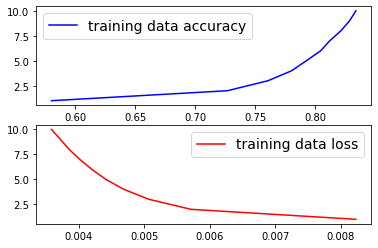

In [18]:
from matplotlib.pyplot import plot
nepochs = list(range(1,11))
plt.subplot(2,1,1)
plt.plot(trainaccuracy, nepochs, c='b', label='training data accuracy')
plt.legend(prop={'size': 14})
plt.subplot(2,1,2)
plt.plot(trainloss, nepochs, c='r', label='training data loss')
plt.legend(prop={'size': 14})
plt.subplot(2,1,2)

In [19]:
accuracy, loss = test(model, testset)
print(f"Test Dataset - Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}%")
accuracy, loss = test(model, valset)
print(f"Valid Dataset - Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}%")

/var/folders/dw/_3hp0rfn7rngzth_1dc9rh280000gn/T/ipykernel_7747/3064916726.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true.append(torch.tensor(target).numpy())
/var/folders/dw/_3hp0rfn7rngzth_1dc9rh280000gn/T/ipykernel_7747/3064916726.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted.append(torch.tensor(pred).numpy())


Test Dataset - Accuracy: 82.54%, Loss: 0.0037%
Valid Dataset - Accuracy: 81.25%, Loss: 0.0149%


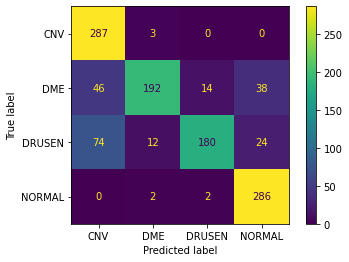

In [21]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cm(p, t):
    y_pred = []
    y_true = []
    for i in range(0, len(p)):
        for j in range(0, len(p[i])):
            y_pred.append(p[i][j])
            y_true.append(t[i][j])
    arr = sklearn.metrics.confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=arr, display_labels=labels)
    disp.plot()
    plt.show()
    
cm(predicted, true)